<a href="https://colab.research.google.com/github/davidguzmanr/Baryogenesis/blob/master/Integro_diferenciales_paralela.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [3]:
!pip install pycuda
!pip install scikit-cuda

     |████████████████████████████████| 1.6MB 24.2MB/s 
     |████████████████████████████████| 61kB 9.3MB/s 
     |████████████████████████████████| 471kB 63.4MB/s 
  Created wheel for pycuda: filename=pycuda-2019.1.2-cp36-cp36m-linux_x86_64.whl size=4535339 sha256=9f90ea2ab2ae3be89a7d1ef45065ec3bf9f092b6175b9d3010a527609b014743
  Stored in directory: /root/.cache/pip/wheels/a6/60/f0/b1c430c73d281ac3e46070480db50f7907364eb6f6d3188396
  Created wheel for pytools: filename=pytools-2019.1.1-py2.py3-none-any.whl size=58424 sha256=e45ff4435930a7d417e25ee5fda2a6e251f3297f30fb0f3a2a5816171dab90ac
  Stored in directory: /root/.cache/pip/wheels/83/df/0b/75ac4572aaa93e3eba6a58472635d0fda907f5f4cf884a3a0c
  Created wheel for mako: filename=Mako-1.1.0-cp36-none-any.whl size=75363 sha256=4168927fb7d58a677b3f83280e0dfc6a340f82594d700628e6abfb19dbd6db60
  Stored in directory: /root/.cache/pip/wheels/98/32/7b/a291926643fc1d1e02593e0d9e247c5a866a366b8343b7aa27
Successfully built pycuda pytools mako
  

In [0]:
import pycuda.gpuarray as gpuarray
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
import skcuda.linalg
import skcuda.integrate
import time
from scipy.integrate import simps

In [0]:
# Constantes
T_c = 160 # Mev
R_c = 1

σ = 50*(197**2) # MeV^3
#σ = 50 

ξ_q = 0.7/197 # Mev
#ξ_q = 0.7 

ζ_q = 0

G = (6.70*(10**(-45)))
#G = 3.7835*10**(-123)

In [0]:
π = np.pi

def g_q(T):
    return (24.604*T**(0.1713))          # según https://arxiv.org/pdf/astro-ph/0304281.pdf ec. (9)

def g_h(T):
    return (2.388*T**(2.287))*10**(-4.0) # según https://arxiv.org/pdf/astro-ph/0304281.pdf ec. (8)
    
def B(T):
    return  g_q(T)*(π**2/90)*(1 - g_h(T)/g_q(T))*(T_c**4)

# Presiones según Kapusta

def Pq(T):
    return g_q(T)*(π**2/90)*T**4 - B(T)

def Ph(T): 
    return g_h(T)*(π**2/90)*T**4

def P(h, T): 
    return h*Ph(T) + (1-h)*Pq(T)

def ΔP(T): 
    return Ph(T) - Pq(T)

# Energías según Csernai pero con coeficientes del Kapusta

def ϵ_q(T):
    return g_q(T)*(π**2/30)*T**4 + B(T)

def ϵ_h(T): 
    return g_h(T)*(π**2/30)*T**4  

def ϵ(h, T):
    return h*ϵ_h(T) + (1-h)*ϵ_q(T)

# Entalpías

def w_q(T): 
    return g_q(T)*(π**2/90)*T**4 +  g_q(T)*(π**2/30)*T**4

def w_h(T): 
    return g_h(T)*(π**2/90)*T**4 +  g_h(T)*(π**2/30)*T**4

def w(h, T):
    return h*w_h(T) + (1-h)*w_q(T)

def Δw(T):
    return w_h(T) - w_q(T)

# Velocidad de las burbujas

def v(T):
    return 3*(1-T/T_c)**(3/2)

# Las demás

def η_q(T):
    return 14.4*T**3

def r0(T):
    return (2*σ)/(Ph(T) - Pq(T)) # r_{*} en los papers

def ΔF0(T):
    return (4/3)*π*σ*(r0(T))**2 # ΔF_{*} en los papers

def I0(T):
    return((16/(3*π))*(σ/(3*T))**(3/2))*((σ*η_q(T)*r0(T))/(ξ_q**4*(Δw(T))**2))

def I(T):
    return (4/π)*((σ/(3*T))**(3/2))*((σ*r0(T)*(3*ζ_q + 4*η_q(T)))/(3*ξ_q**4*(Δw(T))**2))*np.exp(-ΔF0(T)/T)

# Cambio de variable

def dt_dR(R, h, T):
    return (1/R)*((3/(8*π*G*((h*ϵ_h(T))+((1-h)*ϵ_q(T)))))**(1/2))

In [0]:
def V(i, dR, Rs, hs, Ts):  
    
    """
    Esta función es para calcular el volumen, ecuación 16.55 del Kapusta.
    """
    
    global integral_V 
    k = len(Rs)

    if i == 1:
        for j in range(i,k):
            integral_V = integral_V + 3*dR*((1-Ts[j]/T_c)**(3/2))*dt_dR(Rs[j], hs[j], Ts[j])
            
        volume = 4/3*π*(r0(Ts[i]) + integral_V)**3
        return volume
    else:
        integral_V = integral_V - dR*3*((1-Ts[i]/T_c)**(3/2))*dt_dR(Rs[i], hs[i], Ts[i])
        volume = 4/3*π*(r0(Ts[i]) + integral_V)**3 
        return volume

In [0]:
def riemann_h(dR, Rs, hs, Ts):

  global integral_V
  integral_V = 0

  k = len(Rs)

  ys = np.array([I(Ts[i])*(1-hs[i])*hs[i]*V(i, dR, Rs, hs, Ts)*dt_dR(Rs[i], hs[i], Ts[i]) for i in range(len(Rs))], dtype=np.float32)

  # ys_gpu = gpuarray.to_gpu(ys) 

  # # Empezamos la parte en paralelo
  # skcuda.integrate.init()

  # h = skcuda.integrate.trapz(ys_gpu, dx=dR)

  h = simps(ys, Rs)

  return h

  

In [132]:
Rs = np.array([1, 1.00001, 1.00002])
hs = np.array([0,0,0])
Ts = np.array([160, 159.9984, 159.9968000319997])

dR = 0.00001
riemann_h(dR, Rs, hs, Ts)

0.0

In [0]:
def fT(R, h, T, dh_dR):
  return -(dh_dR*((g_h(T)*π**2/30)*T**4 - (g_q(T)*π**2/30)*T**4 - B(T)) + (3/R)*( (2*g_h(T)*π**2/45)*h*T**4 + (1-h)*((2*g_q(T)*π**2/45)*T**4)) )/((4*g_h(T)*π**2/30)*h*T**3 + (1-h)*(4*g_q(T)*π**2/30)*T**3)


In [0]:
def integro_diferencial(R_f, dR):

    R = R_c
    h = 0.0
    T = T_c
    
    Rs = ([R])
    hs = ([h])
    Ts = ([T])
    
    i = 1
    
    #global integral_V

    #t1 = time.time()
    
    while R <= R_f:
              
        if i == 1:
            dh_dR = 0
        else: 
            dh_dR = (hs[-1]-hs[-2])/dR 
                              
        T = T + dR*fT(R,h,T,dh_dR)
        R = R + dR
        h = riemann_h(dR, Rs, hs, Ts)
        #print(i)
        
        if h > 1:
           print("R_final =$(R)")
           break
        
        Rs = np.append(Rs, R)
        hs = np.append(hs, h)
        Ts = np.append(Ts, T)
        
        i = i+1
        
        # if i % 10000 == 0
        #     writedlm("resultados.txt", [Rs hs Ts])
        # end
        
        # if i % 5000 == 0
        #     t2 = time()
        #     hours = (t2-t1)/3600
        #     print("i=$(i), R=$(R), h=$(h)")
        #     print("Van $(hours) horas \n")
                               
    return Rs, hs, Ts

In [140]:
R_f = 1.02
dR = 0.0001

t = time.time()

results = integro_diferencial(R_f, dR)

time.time() - t


1.1401503086090088

In [0]:
Rs, hs, Ts = results

In [0]:
import matplotlib.pyplot as plt

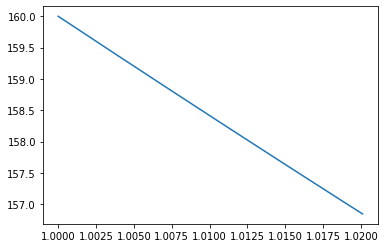

In [143]:
plt.plot(Rs, Ts)